<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/medical_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 医療スコア
- input
    - hospital_master.cav
        - 病院の位置とレーティング
    - pharmacy_nearby.csv
        - 薬局の位置とレーティング
- output
    - mecical_score.csv
        - 医療スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_score_file = 'medical_score.csv'

### 病院

In [6]:
df_hospital_master = pd.read_csv(os.path.join(DIR_NAME, 'hospital_master.csv'))[['名称', '小児', '妊婦', '緯度', '経度', 'rating']]
df_hospital_master['施設分類'] = '病院'
df_hospital_master.loc[df_hospital_master['rating'] == 0, 'rating'] = np.NaN
print(df_hospital_master.shape)

(3571, 7)


In [7]:
df_hospital_master.head()

,名称,小児,妊婦,緯度,経度,rating,施設分類
0,メディカクリニック,1.0,1.0,35.694355,139.762639,3.6,病院
1,九段坂内科消化器内科クリニック,NaN,NaN,35.696069,139.754469,4.2,病院
2,医療法人社団平晴会晴海3丁目クリニック,NaN,NaN,35.654056,139.779257,4.7,病院
3,文京春日こどもクリニック,2.0,NaN,35.710461,139.752461,4.2,病院
4,蔵前まえだクリニック,NaN,NaN,35.706362,139.789713,4.6,病院


### 薬局

In [8]:
df_pharmacy_master = pd.read_csv(os.path.join(DIR_NAME, 'pharmacy_nearby.csv'))[
    ['name', 'lat', 'lng', 'rating']
].rename(columns={'name':'名称', 'lat':'緯度', 'lng':'経度'})
df_pharmacy_master['施設分類'] = '薬局'
df_pharmacy_master.loc[df_pharmacy_master['rating'] == 0, 'rating'] = np.NaN
print(df_pharmacy_master.shape)

(5980, 5)


In [9]:
df_pharmacy_master.head()

,名称,緯度,経度,rating,施設分類
0,日本調剤㈱,35.681553,139.769161,2.5,薬局
1,アイン薬局 グランスタ丸の内店,35.682737,139.766298,4.0,薬局
2,ココカラファイン ヤエチカ北口店,35.681502,139.769801,3.1,薬局
3,ココカラファイン薬局 ヤエチカ北口店,35.681495,139.769810,3.7,薬局
4,ウエルシア東京ミッドタウン八重洲店 (調剤薬局),35.679466,139.769185,3.0,薬局


### 人口マスタ

In [10]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


In [11]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [12]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

## 医療スコア

In [13]:
%%time
# 近い5件の距離の平均
df_pop_master['病院(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_hospital_master, '病院', 'mean', 5)
# 0.5km以内の施設の数
df_pop_master['病院(数)'] = get_value_of_nearest_facility(df_pop_master, df_hospital_master, '病院', 'count', 0.5)

df_pediatrics = df_hospital_master[df_hospital_master['小児'].notna()]
# 近い5件の距離の距離
df_pop_master['小児科(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_pediatrics, '病院', 'mean', 5)
# 0.5km以内の施設の数
df_pop_master['小児科(数)'] = get_value_of_nearest_facility(df_pop_master, df_pediatrics, '病院', 'count', 0.5)

# 近い5件の距離の平均
df_pop_master['薬局(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_pharmacy_master, '薬局', 'mean', 5)
# 0.5km以内の施設の数
df_pop_master['薬局(数)'] = get_value_of_nearest_facility(df_pop_master, df_pharmacy_master, '薬局', 'count', 0.5)

CPU times: user 25min 48s, sys: 4.9 s, total: 25min 53s
Wall time: 26min 7s


In [14]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 12)


,地域ID,市区町村名,町名,町丁目,緯度,経度,病院(平均距離),病院(数),小児科(平均距離),小児科(数),薬局(平均距離),薬局(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.256831,8,0.344824,4,0.202633,13
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.460269,2,0.513721,2,0.387554,5
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.252460,13,0.423147,3,0.214938,12
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.143525,8,0.496290,2,0.122312,14
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.262058,13,0.466893,4,0.225793,18


### 病院スコア

In [15]:
all_feature_list = []
all_score_list = []

In [16]:
score_name = '病院スコア'
feature_list = {
    '病院(平均距離)':   {'sort': -1, 'weight': 1}, 
    '病院(数)':         {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

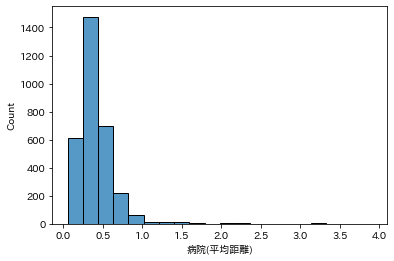

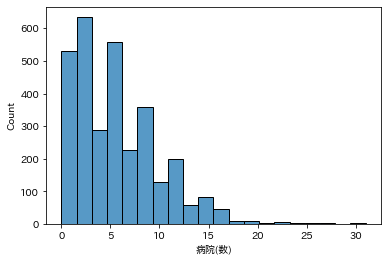

In [17]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [18]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

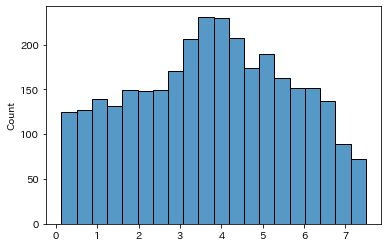

In [19]:
sns.histplot(_tmp_score, bins=20)
plt.show()

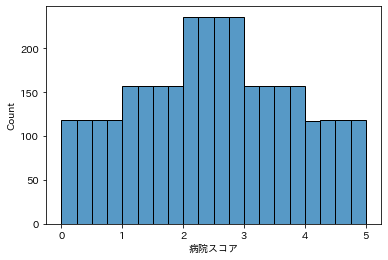

In [20]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

### 小児科スコア

In [21]:
score_name = '小児科スコア'
feature_list = {
    '小児科(平均距離)':   {'sort': -1, 'weight': 1}, 
    '小児科(数)':         {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

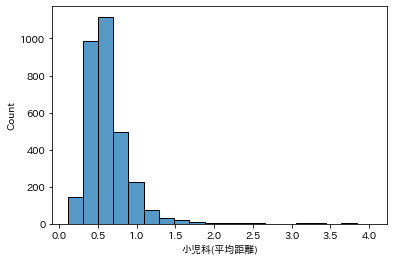

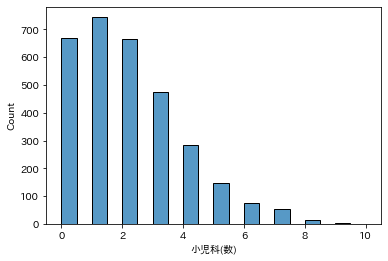

In [22]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [23]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

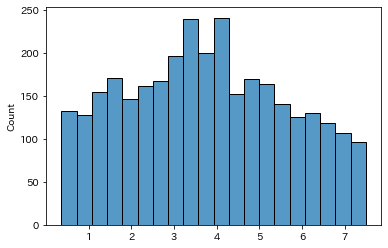

In [24]:
sns.histplot(_tmp_score, bins=20)
plt.show()

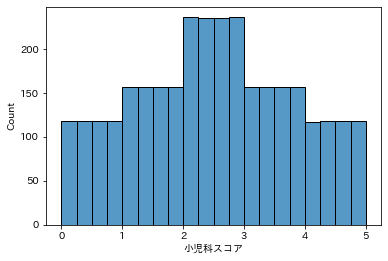

In [25]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

### 薬局スコア

In [26]:
score_name = '薬局スコア'
feature_list = {
    '薬局(平均距離)':   {'sort': -1, 'weight': 1}, 
    '薬局(数)':         {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

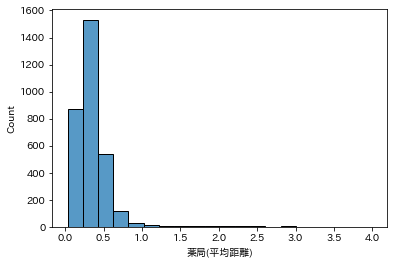

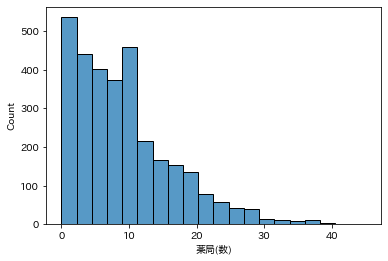

In [27]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [28]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

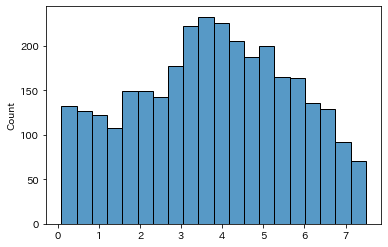

In [29]:
sns.histplot(_tmp_score, bins=20)
plt.show()

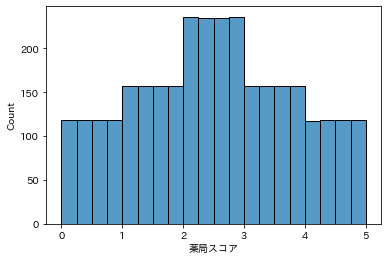

In [30]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

### 医療スコア

In [31]:
score_name = '医療スコア'
feature_list = {
    '病院スコア':   {'sort': 1, 'weight': 1}, 
    '小児科スコア': {'sort': 1, 'weight': 1},
    '薬局スコア':   {'sort': 1, 'weight': 1},
}
all_score_list.append(score_name)

In [32]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

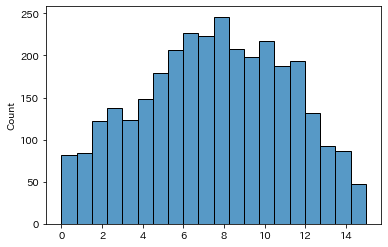

In [33]:
sns.histplot(_tmp_score, bins=20)
plt.show()

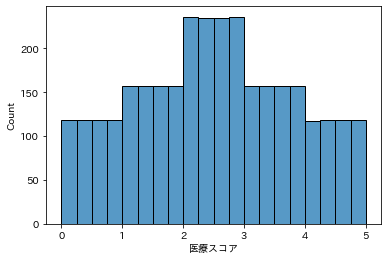

In [34]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

### 保存

In [35]:
all_feature_list

['病院(平均距離)', '病院(数)', '小児科(平均距離)', '小児科(数)', '薬局(平均距離)', '薬局(数)']

In [36]:
all_score_list

['病院スコア', '小児科スコア', '薬局スコア', '医療スコア']

In [37]:
for col in [col for col in all_feature_list if '距離' in col]:
    df_pop_master[col] = df_pop_master[col].round(3)

for col in all_score_list:
    df_pop_master[col] = df_pop_master[col].round(3)

In [38]:
df_pop_master[
    ['地域ID'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

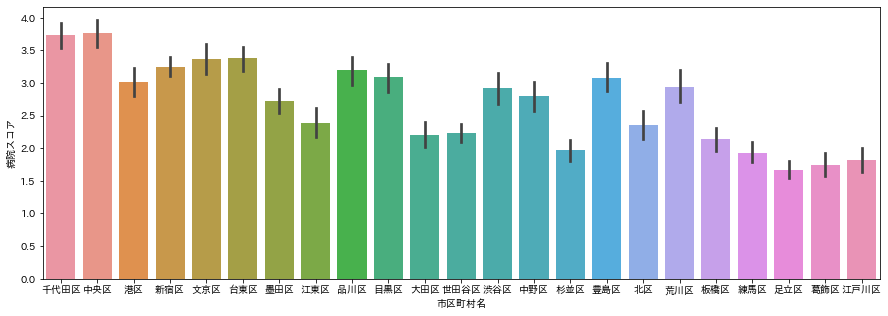

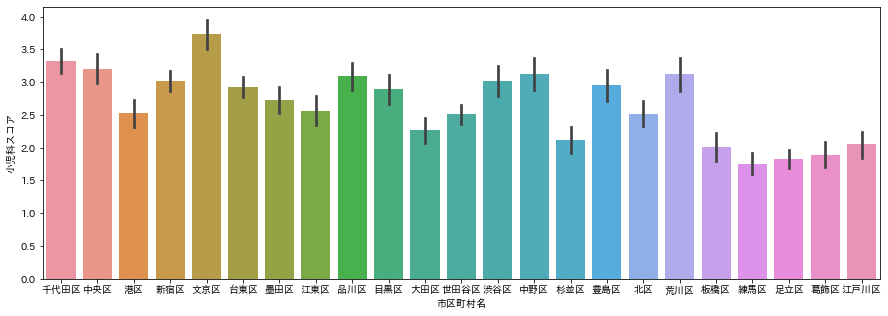

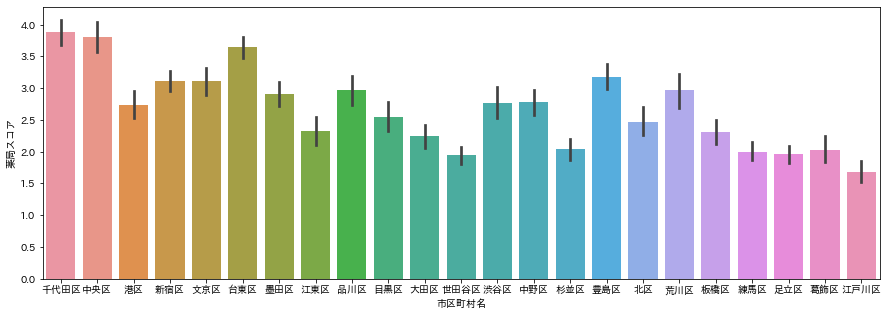

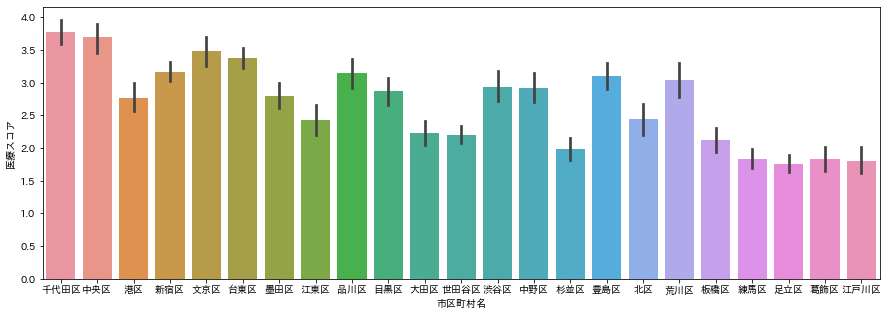

In [39]:
for _score in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_pop_master)
    plt.show()

In [40]:
def get_score_top(df_data, target, ):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [41]:
df_level = get_score_top(df_pop_master, '病院')
print(df_level.shape)
df_level.head(10)

(911, 6)


,市区町村名,町名,町丁目,病院(平均距離),病院(数),病院スコア
0,港区,新橋,新橋２丁目,0.054,25,5.000
1,渋谷区,道玄坂,道玄坂２丁目,0.076,20,4.998
2,中央区,銀座,銀座１丁目,0.108,22,4.996
3,千代田区,内幸町,内幸町２丁目,0.114,24,4.994
4,品川区,大井,大井１丁目,0.103,18,4.992
5,江戸川区,西葛西,西葛西６丁目,0.088,17,4.989
6,港区,西新橋,西新橋１丁目,0.123,30,4.987
7,港区,虎ノ門,虎ノ門１丁目,0.123,22,4.981
8,中央区,日本橋堀留町,日本橋堀留町２丁目,0.121,20,4.979
9,豊島区,北大塚,北大塚２丁目,0.119,18,4.977


In [42]:
df_level.tail(10)

,市区町村名,町名,町丁目,病院(平均距離),病院(数),病院スコア
901,大田区,昭和島,昭和島１丁目,0.934,0,0.157
902,江戸川区,東篠崎町,東篠崎町,0.958,0,0.146
903,足立区,神明,神明１丁目,0.995,0,0.132
904,江東区,夢の島,夢の島１丁目,1.344,0,0.093
905,品川区,東八潮,東八潮,1.360,0,0.091
906,大田区,東海,東海１丁目,1.505,0,0.074
907,大田区,京浜島,京浜島１丁目,1.759,0,0.049
908,江東区,新木場,新木場１丁目,2.013,0,0.042
909,大田区,城南島,城南島７丁目,2.732,0,0.023
910,江東区,若洲,若洲１丁目,3.156,0,0.013


In [43]:
df_level = get_score_top(df_pop_master, '小児科')
print(df_level.shape)
df_level.head(10)

(911, 6)


,市区町村名,町名,町丁目,小児科(平均距離),小児科(数),小児科スコア
0,渋谷区,道玄坂,道玄坂２丁目,0.157,10,5.000
1,江戸川区,一之江,一之江８丁目,0.108,8,4.998
2,文京区,小石川,小石川１丁目,0.153,8,4.996
3,江東区,東陽,東陽３丁目,0.200,8,4.992
4,豊島区,南大塚,南大塚２丁目,0.201,8,4.989
5,渋谷区,桜丘町,桜丘町,0.157,7,4.987
6,港区,白金,白金１丁目,0.159,7,4.985
7,新宿区,改代町,改代町,0.163,7,4.983
8,江東区,南砂,南砂６丁目,0.165,7,4.979
9,江戸川区,西葛西,西葛西３丁目,0.224,9,4.977


In [44]:
df_level.tail(10)

,市区町村名,町名,町丁目,小児科(平均距離),小児科(数),小児科スコア
901,江戸川区,東篠崎町,東篠崎町,1.454,0,0.132
902,江東区,夢の島,夢の島１丁目,1.599,0,0.108
903,大田区,羽田空港,羽田空港１丁目,1.657,0,0.093
904,大田区,東海,東海１丁目,1.799,0,0.070
905,品川区,東八潮,東八潮,1.917,0,0.062
906,大田区,京浜島,京浜島１丁目,1.987,0,0.059
907,江東区,青海,青海１丁目,2.066,0,0.057
908,江東区,新木場,新木場１丁目,2.164,0,0.053
909,大田区,城南島,城南島１丁目,3.077,0,0.023
910,江東区,若洲,若洲１丁目,3.349,0,0.019


In [45]:
df_level = get_score_top(df_pop_master, '薬局')
print(df_level.shape)
df_level.head(10)

(911, 6)


,市区町村名,町名,町丁目,薬局(平均距離),薬局(数),薬局スコア
0,台東区,東上野,東上野２丁目,0.040,38,5.000
1,台東区,上野,上野６丁目,0.070,45,4.998
2,千代田区,神田駿河台,神田駿河台２丁目,0.059,34,4.996
3,豊島区,西池袋,西池袋１丁目,0.083,40,4.992
4,千代田区,鍛冶町,鍛冶町２丁目,0.086,35,4.989
5,新宿区,西新宿,西新宿１丁目,0.091,36,4.985
6,中央区,銀座,銀座７丁目,0.080,29,4.983
7,葛飾区,東金町,東金町１丁目,0.069,25,4.981
8,墨田区,錦糸,錦糸３丁目,0.079,26,4.979
9,品川区,旗の台,旗の台２丁目,0.086,28,4.977


In [46]:
df_level.tail(10)

,市区町村名,町名,町丁目,薬局(平均距離),薬局(数),薬局スコア
901,大田区,昭和島,昭和島１丁目,0.830,0,0.144
902,千代田区,千代田,千代田,0.860,0,0.134
903,世田谷区,砧公園,砧公園,0.863,0,0.129
904,江東区,青海,青海１丁目,1.261,0,0.074
905,大田区,京浜島,京浜島１丁目,1.363,0,0.070
906,江東区,夢の島,夢の島１丁目,1.480,0,0.057
907,品川区,東八潮,東八潮,1.720,0,0.051
908,江東区,新木場,新木場１丁目,2.128,0,0.036
909,大田区,城南島,城南島１丁目,2.311,0,0.030
910,江東区,若洲,若洲１丁目,3.238,0,0.008


In [47]:
df_level = get_score_top(df_pop_master, '医療')
print(df_level.shape)
df_level.head(10)

(911, 4)


,市区町村名,町名,町丁目,医療スコア
0,渋谷区,道玄坂,道玄坂２丁目,5.000
1,江戸川区,西葛西,西葛西６丁目,4.998
2,豊島区,西池袋,西池袋１丁目,4.996
3,台東区,上野,上野６丁目,4.994
4,新宿区,改代町,改代町,4.992
5,葛飾区,東金町,東金町１丁目,4.988
6,文京区,小石川,小石川１丁目,4.985
7,中央区,日本橋堀留町,日本橋堀留町２丁目,4.983
8,墨田区,錦糸,錦糸３丁目,4.981
9,北区,赤羽,赤羽２丁目,4.979


In [48]:
df_level.tail(10)

,市区町村名,町名,町丁目,医療スコア
901,世田谷区,砧公園,砧公園,0.172
902,大田区,昭和島,昭和島１丁目,0.153
903,江東区,青海,青海２丁目,0.102
904,大田区,東海,東海３丁目,0.079
905,江東区,夢の島,夢の島１丁目,0.073
906,品川区,東八潮,東八潮,0.056
907,大田区,京浜島,京浜島１丁目,0.051
908,江東区,新木場,新木場１丁目,0.045
909,大田区,城南島,城南島１丁目,0.023
910,江東区,若洲,若洲１丁目,0.013
